In [1]:
import nibabel as nib
from monai.data import DataLoader, Dataset
from monai.config import print_config
import torch
import torch.nn as nn

# Create an instance of MSELoss
mse_loss = nn.MSELoss()

# Example tensors
output = torch.tensor([1.0, 2.0], requires_grad=True)  # Predictions
target = torch.tensor([1.0, 4.0])  # Ground truth

# Calculate loss
loss = mse_loss(output, target)

# Print the loss
print("MSE Loss:", loss.item())
# Print MONAI config to ensure compatibility
print_config()


KeyboardInterrupt: 

In [ ]:
import monai
from monai.utils.enums import TransformBackends
from monai.config.type_definitions import NdarrayOrTensor
from monai.config import DtypeLike, KeysCollection
from monai.transforms import Transform, Compose, MapTransform
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    RandSpatialCropd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    ToTensord,
)
from config.configp import get_args
import numpy as np
import torch



# from __future__ import annotations

import logging
import sys
import time
import warnings
from collections.abc import Mapping, Sequence
from copy import deepcopy
from functools import partial
from typing import Any, Callable

import numpy as np
import torch
import torch.nn as nn
from collections.abc import Callable, Hashable, Mapping
from monai.config import DtypeLike
from monai.config.type_definitions import NdarrayOrTensor
from monai.data.meta_obj import get_track_meta
from monai.data.meta_tensor import MetaTensor
from monai.data.utils import is_no_channel, no_collation
from monai.networks.layers.simplelayers import (
    ApplyFilter,
    EllipticalFilter,
    GaussianFilter,
    LaplaceFilter,
    MeanFilter,
    SavitzkyGolayFilter,
    SharpenFilter,
    median_filter,
)
from monai.transforms.inverse import InvertibleTransform
from monai.transforms.traits import MultiSampleTrait
from monai.transforms.transform import Randomizable, RandomizableTrait, RandomizableTransform, Transform
from monai.transforms.utils import (
    extreme_points_to_image,
    get_extreme_points,
    map_binary_to_indices,
    map_classes_to_indices,
)
from monai.transforms.utils_pytorch_numpy_unification import concatenate, in1d, moveaxis, unravel_indices
from monai.utils import (
    MetaKeys,
    TraceKeys,
    convert_data_type,
    convert_to_cupy,
    convert_to_numpy,
    convert_to_tensor,
    ensure_tuple,
    look_up_option,
    min_version,
    optional_import,
)
from monai.utils.enums import TransformBackends
from monai.utils.misc import is_module_ver_at_least
from monai.utils.type_conversion import convert_to_dst_type, get_equivalent_dtype

# args = get_args()
# crop_size=args.crop_size

class ConvertToMultiChannelBasedOnBratsClasses(Transform):
    """
    Convert labels to multi channels based on brats18 classes:
    label 1 is the necrotic and non-enhancing tumor core
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).
    """

    backend = [TransformBackends.TORCH, TransformBackends.NUMPY]

    def __call__(self, img: NdarrayOrTensor) -> NdarrayOrTensor:
        # if img has channel dim, squeeze it
        if img.ndim == 4 and img.shape[0] == 1:
            img = img.squeeze(0)

        result = [(img == 1) | (img == 3), (img == 1) | (img == 3) | (img == 2), img == 3]
        print("result shape is", result[0].shape)
        # merge labels 1 (tumor non-enh) and 4 (tumor enh) and 2 (large edema) to WT
        # label 4 is ET
        return torch.stack(result, dim=0) if isinstance(img, torch.Tensor) else np.stack(result, axis=0)

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.ConvertToMultiChannelBasedOnBratsClasses`.
    Convert labels to multi channels based on brats18 classes:
    label 1 is the necrotic and non-enhancing tumor core
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).
    """

    backend = ConvertToMultiChannelBasedOnBratsClasses.backend

    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.converter = ConvertToMultiChannelBasedOnBratsClasses()

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.converter(d[key])
            print("d[key] shape is", d[key].shape)
        return d
class PrintDtypeTransform(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            print(f"Key: {key}, dtype: {data[key].dtype}, shape: {data[key].shape}")
        return data

class SqueezeDimsTransform(Transform):
    def __init__(self, keys, dims):
        self.keys = keys
        self.dims = dims

    def __call__(self, data):
        for key in self.keys:
            if key in data:
                # Remove specified dimensions
                #print("Data old shape", data[key].shape)
                data[key] = np.squeeze(data[key], axis=self.dims)
                #print("Data new shape", data[key].shape)
        return data

# def get_train_transforms(crop_size):
#     print("crop_size is", crop_size)
#     return monai.transforms.Compose([
#         LoadImaged(keys=["t1n", "t2w", "t1c", "t2f", 'mask']),  # Assuming images and masks are loaded from file paths
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         EnsureChannelFirstd(keys=["t1n", "t2w", "t1c", "t2f", 'mask']),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         ConvertToMultiChannelBasedOnBratsClassesd(keys="mask"),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandSpatialCropd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], roi_size=crop_size, random_size=False),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandFlipd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], prob=0.5, spatial_axis=0),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandFlipd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], prob=0.5, spatial_axis=1),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandFlipd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], prob=0.5, spatial_axis=2),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         NormalizeIntensityd(keys=["t1n", "t2w", "t1c", "t2f", 'mask']),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandScaleIntensityd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], factors=0.1, prob=0.5),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandShiftIntensityd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], offsets=0.1, prob=0.5),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         SqueezeDimsTransform(keys=["t1n", "t2w", "t1c", "t2f"], dims=0),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         ToTensord(keys=["t1n", "t2w", "t1c", "t2f", 'mask']),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask'])
#     ])

In [ ]:
data = [
    {
        "label": './output/mask_all_image_10.nii.gz'
        
        
        
    }
]

# Define the transformations
transforms = Compose([
    LoadImaged(keys=["label"]),               # Load image and label
    # EnsureChannelFirstd(keys=["label"]),      # Ensure channels are first
    # ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),  # Apply custom transform on segmentation mask
    ToTensord(keys=["label"])                 # Convert to PyTorch tensors
])
transformed_data = transforms(data[0])

# Step 4: Inspect the transformed results
transformed_mask1 = transformed_data["label"]
# print("Transformed mask shape:", np.unique(transformed_mask1[2,:,:,:]))
print("Transformed mask dtype:", (torch.nonzero(transformed_mask1==2)))
print("Transformed mask dtype:", torch.sum(transformed_mask1==3))

In [ ]:
import torch
import torch.nn.functional as F
import monai
from monai.utils.enums import TransformBackends
from monai.config.type_definitions import NdarrayOrTensor
from monai.config import DtypeLike, KeysCollection
from monai.transforms import Transform, Compose, MapTransform
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    RandSpatialCropd,
    RandFlipd,
    RandRotated,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    ToTensord,
)
from config.configp import get_args
import numpy as np
import torch



# from __future__ import annotations

import logging
import sys
import time
import warnings
from collections.abc import Mapping, Sequence
from copy import deepcopy
from functools import partial
from typing import Any, Callable

import numpy as np
import torch
import torch.nn as nn
from collections.abc import Callable, Hashable, Mapping
from monai.config import DtypeLike
from monai.config.type_definitions import NdarrayOrTensor
from monai.data.meta_obj import get_track_meta
from monai.data.meta_tensor import MetaTensor
from monai.data.utils import is_no_channel, no_collation
from monai.networks.layers.simplelayers import (
    ApplyFilter,
    EllipticalFilter,
    GaussianFilter,
    LaplaceFilter,
    MeanFilter,
    SavitzkyGolayFilter,
    SharpenFilter,
    median_filter,
)
from monai.transforms.inverse import InvertibleTransform
from monai.transforms.traits import MultiSampleTrait
from monai.transforms.transform import Randomizable, RandomizableTrait, RandomizableTransform, Transform
from monai.transforms.utils import (
    extreme_points_to_image,
    get_extreme_points,
    map_binary_to_indices,
    map_classes_to_indices,
)
from monai.transforms.utils_pytorch_numpy_unification import concatenate, in1d, moveaxis, unravel_indices
from monai.utils import (
    MetaKeys,
    TraceKeys,
    convert_data_type,
    convert_to_cupy,
    convert_to_numpy,
    convert_to_tensor,
    ensure_tuple,
    look_up_option,
    min_version,
    optional_import,
)
from monai.utils.enums import TransformBackends
from monai.utils.misc import is_module_ver_at_least
from monai.utils.type_conversion import convert_to_dst_type, get_equivalent_dtype

import cv2
import numpy as np
from monai.transforms import Transform, MapTransform
from typing import Hashable, Mapping
from scipy.ndimage import binary_dilation, binary_erosion, binary_opening, binary_closing
# from skimage.morphology import binary_dilation, binary_erosion, binary_opening, binary_closing
import random


class ConvertToMultiChannelBasedOnBratsClasses(Transform):
    """
    Convert labels to multi channels based on brats18 classes:
    label 1 is the necrotic and non-enhancing tumor core
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).
    """

    backend = [TransformBackends.TORCH, TransformBackends.NUMPY]

    def __call__(self, img: NdarrayOrTensor) -> NdarrayOrTensor:
        # if img has channel dim, squeeze it
        if img.ndim == 4 and img.shape[0] == 1:
            img = img.squeeze(0)

        # print("size of back ground is", torch.sum(img==0))

        # result = [(img == 1) | (img == 3), (img == 1) | (img == 3) | (img == 2), (img == 3)]
        result = [(img == 0), (img == 1), (img == 2), (img == 3)]
        
        # print("result shape is", result.shape)
        # merge labels 1 (tumor non-enh) and 4 (tumor enh) and 2 (large edema) to WT
        # label 4 is ET
        # if isinstance(img, torch.Tensor):
        #     return torch.stack(result, dim=0).float()
        # else:
        #     return np.stack(result, axis=0).astype(float)
        return torch.stack(result, dim=0).float() if isinstance(img, torch.Tensor) else np.stack(result, axis=0).astype(float)

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.ConvertToMultiChannelBasedOnBratsClasses`.
    Convert labels to multi channels based on brats18 classes:
    label 1 is the necrotic and non-enhancing tumor core
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).
    """

    backend = ConvertToMultiChannelBasedOnBratsClasses.backend

    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.converter = ConvertToMultiChannelBasedOnBratsClasses()

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.converter(d[key])
            # print("d[key] shape is", d[key].shape)
        return d

class RandomMorphologyTransform(Transform):
    def __init__(self, operations=None, min_kernel_size=1, max_kernel_size=5, min_iterations=1, max_iterations=3):
        """
        Perform random morphological operations (dilation, erosion, opening, or closing) on 3D volumes.

        Args:
            operations (list of str): The types of morphological operations to randomly select from.
            min_kernel_size (int): Minimum size of the structuring element (cube in 3D).
            max_kernel_size (int): Maximum size of the structuring element (cube in 3D).
            min_iterations (int): Minimum number of times the operation is applied.
            max_iterations (int): Maximum number of times the operation is applied.
        """
        self.operations = operations if operations else ['dilation']
        self.min_kernel_size = min_kernel_size
        self.max_kernel_size = max_kernel_size
        self.min_iterations = min_iterations
        self.max_iterations = max_iterations

    def apply_morphology(self, volumes: np.ndarray) -> np.ndarray:
        # Randomly select operation, kernel size, and iterations
        operation = random.choice(self.operations)
        kernel_size = random.randint(self.min_kernel_size, self.max_kernel_size)
        iterations = random.randint(self.min_iterations, self.max_iterations)

        # Define a 3D structuring element (cube)
        struct_elem = np.ones((kernel_size, kernel_size, kernel_size), dtype=np.uint8)

        num_indices_to_apply = random.choice([1, 2, 3])

        print("num_indices_to_apply", num_indices_to_apply)
        
        # Randomly select the specific indices to apply the operation to
        indices_to_apply = random.sample([1, 2, 3], num_indices_to_apply)

        print("indices_to_apply", indices_to_apply)

        # Apply the selected morphological operation to the randomly chosen indices
        if operation == 'closing':
            print(f"Applying Closing on indices {indices_to_apply}")
            return np.array([
                binary_closing(volume, structure=struct_elem, iterations=iterations).astype(volume.dtype)
                if idx in indices_to_apply else volume
                for idx, volume in enumerate(volumes)
            ])
        elif operation == 'erosion':
            print(f"Applying Erosion on indices {indices_to_apply}")
            return np.array([
                binary_erosion(volume, structure=struct_elem, iterations=iterations).astype(volume.dtype)
                if idx in indices_to_apply else volume
                for idx, volume in enumerate(volumes)
            ])
        elif operation == 'opening':
            print(f"Applying Opening on indices {indices_to_apply}")
            return np.array([
                binary_opening(volume, structure=struct_elem, iterations=iterations).astype(volume.dtype)
                if idx in indices_to_apply else volume
                for idx, volume in enumerate(volumes)
            ])
        elif operation == 'dilation':
            print(f"Applying Dilation on indices {indices_to_apply}")
            return np.array([
                binary_dilation(volume, structure=struct_elem, iterations=iterations).astype(volume.dtype)
                if idx in indices_to_apply else volume
                for idx, volume in enumerate(volumes)
            ])
        return volumes

    def __call__(self, volumes: np.ndarray) -> np.ndarray:
        if volumes.ndim == 5:
            # Apply transformation to each volume in parallel
            return self.apply_morphology(volumes)
        elif volumes.ndim == 4:
            # Apply transformation to each volume in parallel
            return self.apply_morphology(volumes)
        else:
            raise ValueError(f"Expected a 4D or 5D tensor, got {volumes.ndim}D.")

class RandomMorphologyTransformd(MapTransform):
    """
    Dictionary-based wrapper for RandomMorphologyTransform to work with MONAI pipelines.
    """
    def __init__(self, keys: Hashable, operations=None, min_kernel_size=1, max_kernel_size=5, 
                 min_iterations=1, max_iterations=3, prob=0.5, allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.transform = RandomMorphologyTransform(operations, min_kernel_size, max_kernel_size, min_iterations, max_iterations)
        self.prob = prob
        self.count=0
        

    def __call__(self, data: Mapping[Hashable, np.ndarray]) -> Mapping[Hashable, np.ndarray]:
        d = dict(data)
        for key in self.key_iterator(d):
            volume = d[key]

            # Convert torch tensor to numpy array if necessary
            if isinstance(volume, torch.Tensor):
                volume = volume.cpu().numpy()

            # Apply the random morphological transformation on the volume
            if random.random() < self.prob:
                print("VOLUME SHAPE IS", volume.shape)
                for idx, volum in enumerate(volume):
                    print(f"idx is____{idx}_________volume shape is__{volum.shape}")
                volume = self.transform(volume)

            # Convert back to torch tensor and ensure type consistency
            d[key] = torch.from_numpy(volume).float()
            # print("d[key]", d[key].shape)
        self.count += 1
        # print("self.count", self.count)
        return d




data = [
    {
        "label": f'./output/mask_all_image_187.nii.gz'
        
        
    }
]

# Define the transformations
transforms = Compose([
    LoadImaged(keys=["label"]),               # Load image and label
    # EnsureChannelFirstd(keys=["label"]),      # Ensure channels are first
    # ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),  # Apply custom transform on segmentation mask
    # RandFlipd(keys=['label'], prob=0.5, spatial_axis=0),
    # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
    # RandFlipd(keys=['label'], prob=1, spatial_axis=2),
    # RandRotated(keys=['label'], prob=2, range_x=(-15, 15), range_y=(-15, 15), range_z=(-15, 15)),
    # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
    # RandFlipd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], prob=0.5, spatial_axis=2),
    # RandomMorphologyTransformd(keys=['label'], min_kernel_size=1, max_kernel_size=5, min_iterations=1, max_iterations=10, prob=1),  
    ToTensord(keys=["label"])                 # Convert to PyTorch tensors
])
trans1=transforms(data)
print(trans1[0]['label'].shape)
data = [
    {
        "label": f'./output/reconstructed_all_image_187.nii.gz'
        
        
    }
]
transforms = Compose([
    LoadImaged(keys=["label"]),               # Load image and label
    # EnsureChannelFirstd(keys=["label"]),      # Ensure channels are first
    # ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),  # Apply custom transform on segmentation mask
    # RandFlipd(keys=['label'], prob=0.5, spatial_axis=0),
    ToTensord(keys=["label"])                 # Convert to PyTorch tensors
])
trans2=transforms(data)
print(trans2[0]['label'].shape)

transformed_data1 = trans1[0]['label']

transformed_data2 = trans2[0]['label']
# transformed_data2=F.softmax(transformed_data2, dim=0)
# transformed_data2=transformed_data2.permute(0, 1, 2, 3)
# transformed_data2 = torch.argmax(transformed_data2, axis=0)
# transformed_data1=F.softmax(transformed_data1, dim=0)
# transformed_data1=transformed_data1.permute(0, 1, 2, 3)
transformed_data1 = torch.argmax(transformed_data1, axis=0)
transformed_data2 = torch.argmax(transformed_data2, axis=0)


print("Transformed1 unique labels:", np.unique(transformed_data1))
print("Transformed2 unique labels:", np.unique(transformed_data2))

# Step 4: Inspect the transformed results
# transformed_mask1 = transformed_data[0]
# transformed_mask2 = transformed_data[0]

# print("transformed_mask2 shape is", transformed_mask2.shape)
# transformed_mask_label=(transformed_mask2[1])
# print("Transformed mask shape:", np.unique(transformed_mask2))
# print("Transformed mask shape:", torch.sum(transformed_mask_label[True]))
# print("Transformed mask dtype:", torch.sum(transformed_mask2[transformed_mask_label]))
# target_value = 3.0

# # Count the number of voxels with the value 3.0
# voxel_count = np.count_nonzero(transformed_mask2 == target_value)

# print(f"Number of voxels with the value {target_value}: {voxel_count}")
print("transformed_data1 size", transformed_data1.shape)
print("transformed_data2 size", transformed_data2.shape)
# print("transformed_data2 size", transformed_data1.dtype)
# print("transformed_data2 size", transformed_data2.dtype)








# data = [
#     {
#         "label": f'./output/mask_all_image_99.nii.gz'
        
        
#     }
# ]

# # Define the transformations
# transforms = Compose([
#     LoadImaged(keys=["label"]),               # Load image and label
#     # EnsureChannelFirstd(keys=["label"]),      # Ensure channels are first
#     # ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),  # Apply custom transform on segmentation mask
#     # RandFlipd(keys=['label'], prob=1, spatial_axis=2),
#     # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#     # RandFlipd(keys=['label'], prob=1, spatial_axis=2),
#     # RandRotated(keys=['label'], prob=1, range_x=(-15, 15), range_y=(-15, 15), range_z=(-15, 15)),
#     # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#     # RandFlipd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], prob=0.5, spatial_axis=2),
#     RandomMorphologyTransformd(keys=['label'], min_kernel_size=1, max_kernel_size=5, min_iterations=1, max_iterations=20, prob=1),  
#     ToTensord(keys=["label"])                 # Convert to PyTorch tensors
# ])
# trans3=transforms(data)
# print(trans3[0]['label'].shape)
# data = [
#     {
#         "label": f'./output/reconstructed_all_image_99.nii.gz'
        
        
#     }
# ]
# transforms = Compose([
#     LoadImaged(keys=["label"]),               # Load image and label
#     # EnsureChannelFirstd(keys=["label"]),      # Ensure channels are first
#     # ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),  # Apply custom transform on segmentation mask
#     # RandFlipd(keys=['label'], prob=1, spatial_axis=2),
#     # RandRotated(keys=['label'], prob=1, range_x=(-15, 15), range_y=(-15, 15), range_z=(-15, 15)),
#     RandomMorphologyTransformd(keys=['label'], min_kernel_size=1, max_kernel_size=5, min_iterations=1, max_iterations=20, prob=1),  
#     ToTensord(keys=["label"])                 # Convert to PyTorch tensors
# ])
# trans4=transforms(data)
# print(trans4[0]['label'].shape)

# transformed_data3 = trans3[0]['label']

# transformed_data4 = trans4[0]['label']
# transformed_data3=F.softmax(transformed_data3, dim=0)
# transformed_data2=transformed_data2.permute(0, 1, 2, 3)
# transformed_data3 = torch.argmax(transformed_data3, axis=0)
# transformed_data1=F.softmax(transformed_data1, dim=0)
# transformed_data1=transformed_data1.permute(0, 1, 2, 3)
# transformed_data4 = torch.argmax(transformed_data4, axis=0)


# Step 4: Inspect the transformed results
# transformed_mask1 = transformed_data[0]
# transformed_mask2 = transformed_data[0]

# print("transformed_mask2 shape is", transformed_mask2.shape)
# transformed_mask_label=(transformed_mask2[1])
# print("Transformed mask shape:", np.unique(transformed_mask2))
# print("Transformed mask shape:", torch.sum(transformed_mask_label[True]))
# print("Transformed mask dtype:", torch.sum(transformed_mask2[transformed_mask_label]))
# target_value = 3.0

# # Count the number of voxels with the value 3.0
# voxel_count = np.count_nonzero(transformed_mask2 == target_value)

# print(f"Number of voxels with the value {target_value}: {voxel_count}")
# print("transformed_data3 size", transformed_data3.shape)
# print("transformed_data4 size", transformed_data4.shape)
# print("transformed_data2 size", transformed_data1.dtype)
# print("transformed_data2 size", transformed_data2.dtype)

In [ ]:
 if isinstance(transformed_data2, torch.Tensor):
        print("Input is a PyTorch tensor.")

len of image shape 3
slice_idx (240, 240)
slice_idx (240, 240)
slice_idx (240, 240)


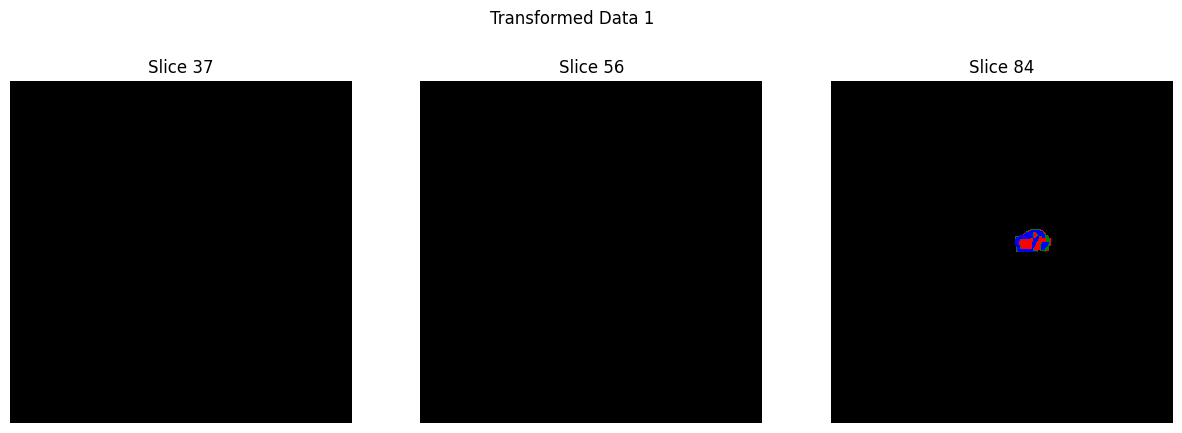

len of image shape 3
slice_idx (240, 240)
slice_idx (240, 240)
slice_idx (240, 240)


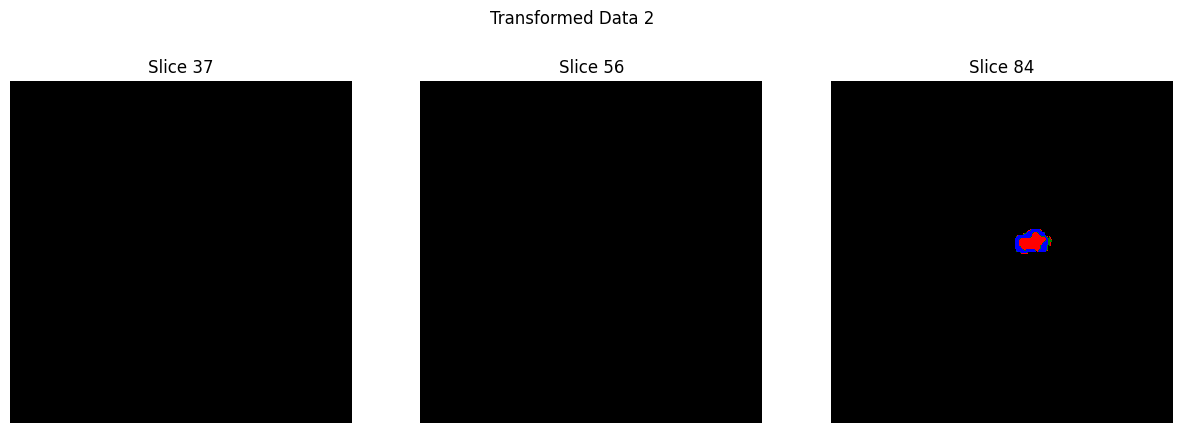

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def visualize_slices(tensor, title='Image', colormap=None):
    """
    Visualize slices of a 3D medical image tensor with a fixed colormap.
    Args:
        tensor (torch.Tensor): The 3D tensor with shape [C, D, H, W] or [D, H, W].
        title (str): The title of the plot.
        colormap (ListedColormap): The colormap to use for visualization.
    """
    # Convert to numpy array for visualization
    img = tensor.cpu().numpy()  # Ensure the tensor is on the CPU and convert to numpy

    # Handle different shapes:
    # If the tensor has 4 dimensions [C, D, H, W], reduce it to [D, H, W] by taking the first channel
    print("len of image shape", len(img.shape))
    if len(img.shape) == 4:
        img = img[3]  # Use the first channel if multiple channels are present
        print(img.shape)

    # Check if the tensor is 3D [D, H, W], else handle as a 2D image
    if len(img.shape) == 3:
        num_slices = img.shape[2]  # Depth dimension
        slice_indices = [num_slices // 3, num_slices // 2, 3 * num_slices // 4]  # Slices to visualize
        # slice_indices = [83, 85, 87]  # Slices to visualize
        fig, axes = plt.subplots(1, len(slice_indices), figsize=(15, 5))
        for i, slice_idx in enumerate(slice_indices):
            print("slice_idx", img[:,:,slice_idx].shape)
            axes[i].imshow(img[:, :, slice_idx], cmap=colormap)
            axes[i].axis('off')
            axes[i].set_title(f'Slice {slice_idx}')
    elif len(img.shape) == 2:
        # If the image is 2D, display it directly
        plt.imshow(img, cmap=colormap)
        plt.axis('off')
        plt.title(title)
    else:
        print("Unexpected tensor shape:", img.shape)
        return

    plt.suptitle(title)
    plt.show()

# Define a fixed colormap with specific colors for each class
num_classes = 4  # Number of classes in your masks
colors = ['black', 'red', 'green', 'blue']  # Define colors for each class
colormap = ListedColormap(colors)

# Visualize slices for transformed_data1
visualize_slices(transformed_data1, title='Transformed Data 1', colormap=colormap)

visualize_slices(transformed_data2, title='Transformed Data 2', colormap=colormap)


# visualize_slices(transformed_data3, title='Transformed Data 3', colormap=colormap)

# visualize_slices(transformed_data4, title='Transformed Data 4', colormap=colormap)

In [44]:
import os
import torch
from matplotlib import pyplot as plt
checkpoint_dir = "./model/checkpoints" 
checkpoint_path = os.path.join(checkpoint_dir, 'vae_checkpoint_latest.pth')
checkpoint = torch.load(checkpoint_path)

# Extract the utilized_encoding tensor
utilized_encoding = checkpoint['Utilized_encoding']

# Check the shape and dtype
print("Utilized Encoding:", utilized_encoding)
print("Shape:", utilized_encoding.shape)
print("Data Type:", utilized_encoding.dtype)
print(len(torch.nonzero(utilized_encoding)))
utilized_encoding_np = utilized_encoding.cpu().numpy()  # Move to CPU if on GPU

# Plotting the histogram
unique_encodings, counts = np.unique(utilized_encoding_np, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(unique_encodings, alpha=0.7, color='blue')  # Bar plot with unique encodings and their counts
plt.title('Bar Plot of Utilized Encoding')
plt.xlabel('Encoding Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Utilized Encoding: metatensor([2.2992e+05, 2.0935e+05, 3.7257e+05,  ..., 8.2933e+08, 4.2903e+04,
        5.6574e+04], device='cuda:0')
Shape: torch.Size([1024])
Data Type: torch.float32
1024


/tmp/ipykernel_5130/2011625268.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


TypeError: bar() missing 1 required positional argument: 'height'

<Figure size 1000x500 with 0 Axes>

Data shape: (4, 240, 240, 128)


TypeError: Invalid shape (128, 240, 240) for image data

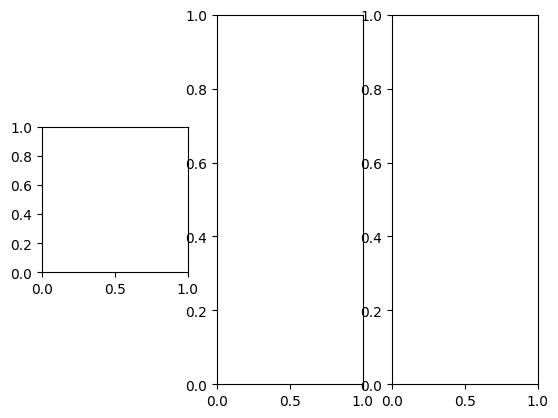

In [14]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the NIfTI file
file_path = './output/reconstructed_all_image_15.nii.gz' # Replace with your file path
img = nib.load(file_path)

# Get the data array from the image
data = img.get_fdata()

# Check the shape of the data to understand the dimensions (e.g., (x, y, z))
print(f"Data shape: {data.shape}")

# Define a function to display slices
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

# Select slices to display (one from each plane)
slice_0 = data[data.shape[0] // 2, :, :]  # Sagittal slice
slice_1 = data[:, data.shape[1] // 2, :]  # Coronal slice
slice_2 = data[:, :, data.shape[2] // 2]  # Axial slice

# Show the slices
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for each plane")
plt.show()

TypeError: Invalid shape (128, 4, 128) for image data

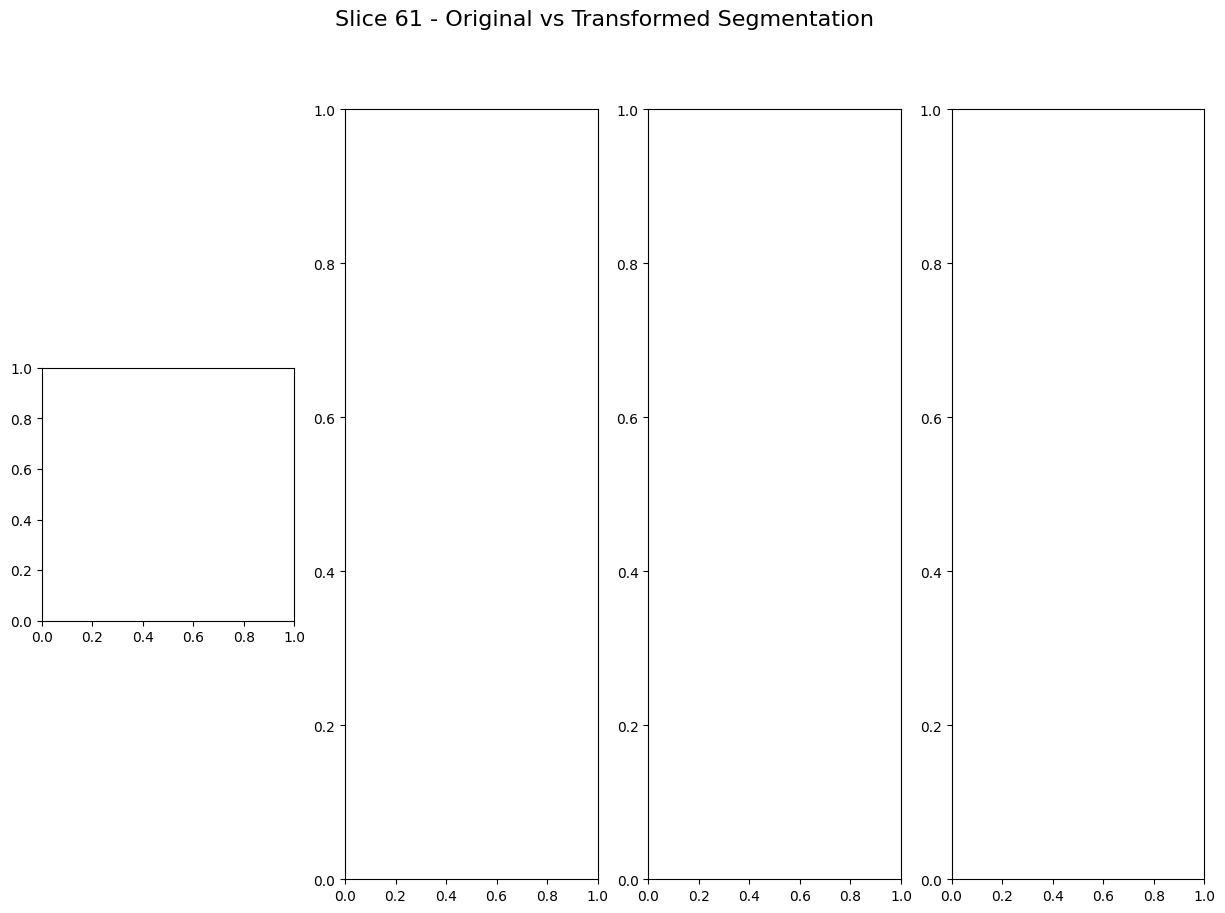

In [634]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ToTensord
# from custom_transforms import ConvertToMultiChannelBasedOnBratsClassesd

# Define the data dictionary for your single image
data = [
    {
        "label": './output/reconstructed_all_image_15.nii.gz'
    }
]

# Define the transformations for original and transformed data
transforms = Compose([
    LoadImaged(keys=["label"]),                    # Load the label
    EnsureChannelFirstd(keys=["label"]),           # Ensure channels are first
    ToTensord(keys=["label"])                      # Convert to PyTorch tensor
])

# Apply the transformations directly
transformed_data = transforms(data[0])
original_label = transformed_data["label"]  # Shape: (Channels, Height, Width, Depth)

# Define and apply the custom transformation for the segmentation label
custom_transform = ConvertToMultiChannelBasedOnBratsClassesd(keys="label")
transformed_label = custom_transform({"label": original_label})["label"]  # Apply the custom transformation

# Get the number of channels and depth (number of slices per channel)
num_channels = transformed_label.shape[0]  # Number of channels after transformation
depth = transformed_label.shape[-1]        # Number of slices in the last dimension

# Visualize the original and transformed segmentation masks
for slice_idx in range(60, 75):
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 10))  # Two rows: original and transformed
    fig.suptitle(f"Slice {slice_idx + 1} - Original vs Transformed Segmentation", fontsize=16)

    # Plot the original segmentation mask slice
    # original_label_slice = original_label[0, :, :, slice_idx].numpy()  # Assuming single channel
    # axes[0, 0].imshow(original_label_slice, cmap='gray')
    # axes[0, 0].set_title("Original Label")
    # axes[0, 0].axis('off')

    # Plot corresponding slices from each channel of the transformed mask
    for channel in range(num_channels):
        transformed_label_slice = transformed_label[channel, :, :, slice_idx].numpy()  # Convert to numpy
        axes[channel].imshow(transformed_label_slice, cmap='gray')
        axes[channel].set_title(f"Channel {channel + 1}")
        axes[channel].axis('off')

    # plt.tight_layout()
    plt.show()




# import matplotlib.pyplot as plt
# import numpy as np
# import nibabel as nib
# from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ToTensord
# from matplotlib.colors import ListedColormap

# # Define color maps for each channel
# def create_colored_image(channel_data, color):
#     """
#     Apply a single color to the channel data.
#     Args:
#         channel_data (np.array): The data of a single channel.
#         color (tuple): RGB tuple for the color.
#     Returns:
#         np.array: The color-mapped channel.
#     """
#     colored_image = np.zeros((channel_data.shape[0], channel_data.shape[1], 3), dtype=np.uint8)
#     colored_image[..., 0] = color[0] * channel_data  # Red channel
#     colored_image[..., 1] = color[1] * channel_data  # Green channel
#     colored_image[..., 2] = color[2] * channel_data  # Blue channel
#     return colored_image

# # Define the data dictionary for your single image
# # data = [
# #     {
# #         "label": './dataset/brats2023/BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii.gz'
# #     }
# # ]

# # # Define the transformations for original and transformed data
# # transforms = Compose([
# #     LoadImaged(keys=["label"]),                    # Load the label
# #     EnsureChannelFirstd(keys=["label"]),           # Ensure channels are first
# #     ToTensord(keys=["label"])                      # Convert to PyTorch tensor
# # ])

# # # Apply the transformations directly
# # transformed_data = transforms(data[0])
# # original_label = transformed_data["label"]  # Shape: (Channels, Height, Width, Depth)

# # # Define and apply the custom transformation for the segmentation label
# # custom_transform = ConvertToMultiChannelBasedOnBratsClassesd(keys="label")
# # transformed_label = custom_transform({"label": original_label})["label"]  # Apply the custom transformation
# original_label=transformed_data1
# transformed_label=transformed_data2
# # Define color maps for each channel (3 channels)
# colors = {
#     0: (1, 1, 0),  # Yellow for channel 1 (Tumor core)
#     1: (0, 1, 0),  # Green for channel 2 (Whole tumor)
#     2: (0, 0, 1)   # Blue for channel 3 (Enhancing tumor)
# }

# # Get the number of channels and depth (number of slices per channel)
# num_channels = transformed_label.shape[0]  # Number of channels after transformation
# depth = transformed_label.shape[-1]        # Number of slices in the last dimension

# # Set the starting and ending slice indices
# start_slice_idx = 71
# end_slice_idx = min(75, depth)  # Ensure end index is within the valid range

# # Visualize the original and transformed segmentation masks with color mapping
# for slice_idx in range(start_slice_idx, end_slice_idx):
    

#     # Plot corresponding slices from each channel of the transformed mask with color mapping
#     for channel in range(num_channels):
#         fig, axes = plt.subplots(2, num_channels, figsize=(15, 10))  # Two rows: original and transformed
#         fig.suptitle(f"Slice {slice_idx + 1} - Original vs Transformed Segmentation", fontsize=16)
    
#         # Plot the original segmentation mask slice
#         original_label_slice = original_label[channel, :, :, slice_idx].numpy()  # Assuming single channel
#         axes[0].imshow(original_label_slice, cmap='gray')
#         axes[0].set_title("Original Label")
#         axes[0].axis('off')
#         transformed_label_slice = transformed_label[channel, :, :, slice_idx].numpy()  # Convert to numpy
#         color_map = colors.get(channel, (0, 0, 0))  # Default to black if channel is not in colors
#         colored_slice = create_colored_image(transformed_label_slice, color_map)

#         axes[1].imshow(colored_slice)
#         axes[1].set_title(f"Channel {channel + 1}")
#         axes[1].axis('off')

#     plt.tight_layout()
#     plt.show()
# import numpy as np
# import nibabel as nib
# from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ToTensord
# from matplotlib.colors import ListedColormap

# def create_colored_image(channel_data, color):
#     """
#     Apply a single color to the channel data.
#     Args:
#         channel_data (np.array): The data of a single channel.
#         color (tuple): RGB tuple for the color.
#     Returns:
#         np.array: The color-mapped channel.
#     """
#     # Normalize the channel data to range [0, 1]
#     normalized_data = np.clip(channel_data, 0, 1)
    
#     # Create a blank RGB image
#     colored_image = np.zeros((normalized_data.shape[0], normalized_data.shape[1], 3), dtype=np.uint8)
    
#     # Apply color to the non-zero regions
#     for c in range(3):
#         colored_image[..., c] = (normalized_data * color[c] * 255).astype(np.uint8)
    
#     return colored_image

# # Define the data dictionary for your single image
# data = [
#     {
#         "label": './dataset/brats2023/BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii.gz'
#     }
# ]

# # Define the transformations for original and transformed data
# transforms = Compose([
#     LoadImaged(keys=["label"]),                    # Load the label
#     EnsureChannelFirstd(keys=["label"]),           # Ensure channels are first
#     ToTensord(keys=["label"])                      # Convert to PyTorch tensor
# ])

# # Apply the transformations directly
# transformed_data = transforms(data[0])
# original_label = transformed_data["label"]  # Shape: (Channels, Height, Width, Depth)

# # Define and apply the custom transformation for the segmentation label
# custom_transform = ConvertToMultiChannelBasedOnBratsClassesd(keys="label")
# transformed_label = custom_transform({"label": original_label})["label"]  # Apply the custom transformation

# # Define color maps for each channel (3 channels)
# colors = {
#     0: (1, 1, 0),  # Yellow for channel 1 (Tumor core)
#     1: (0, 1, 0),  # Green for channel 2 (Whole tumor)
#     2: (0, 0, 1)   # Blue for channel 3 (Enhancing tumor)
# }

# # Get the number of channels and depth (number of slices per channel)
# num_channels = transformed_label.shape[0]  # Number of channels after transformation
# depth = transformed_label.shape[-1]        # Number of slices in the last dimension

# # Set the starting and ending slice indices
# start_slice_idx = 70
# end_slice_idx = min(75, depth)  # Ensure end index is within the valid range

# # Visualize the original and transformed segmentation masks with color mapping
# for slice_idx in range(start_slice_idx, end_slice_idx):
#     fig, axes = plt.subplots(2, num_channels, figsize=(15, 10))  # Two rows: original and transformed
#     fig.suptitle(f"Slice {slice_idx + 1} - Original vs Transformed Segmentation", fontsize=16)

#     # Plot the original segmentation mask slice
#     original_label_slice = original_label[0, :, :, slice_idx].numpy()  # Assuming single channel
#     axes[0, 0].imshow(original_label_slice, cmap='gray')
#     axes[0, 0].set_title("Original Label")
#     axes[0, 0].axis('off')

#     # Plot corresponding slices from each channel of the transformed mask with color mapping
#     for channel in range(num_channels):
#         transformed_label_slice = transformed_label[channel, :, :, slice_idx].numpy()  # Convert to numpy
#         color_map = colors.get(channel, (0, 0, 0))  # Default to black if channel is not in colors
#         colored_slice = create_colored_image(transformed_label_slice, color_map)

#         axes[1, channel].imshow(colored_slice)
#         axes[1, channel].set_title(f"Channel {channel + 1}")
#         axes[1, channel].axis('off')

#     plt.tight_layout()
#     plt.show()

In [58]:
image_path1 = ''
img1 = nib.load(image_path1)

# Get the image data as a NumPy array
img_data1 = img1.get_fdata()
print("img_data1", img_data1.shape)

# image_path2 = './output/mask12.nii.gz'
# img2 = nib.load(image_path2)

# # Get the image data as a NumPy array
# img_data2 = img2.get_fdata()

# image_path3 = './output/reconstructed_image_missing_12.nii.gz'
# img3 = nib.load(image_path3)
# # Get the image data as a NumPy array
# img_data3 = img3.get_fdata()

img_data1 (240, 240, 155)


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegmentationModel(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(SegmentationModel, self).__init__()
        
        # Define 3D convolution layers
        self.conv1 = nn.Conv3d(in_channels, 3, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(3, 3, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(3, num_classes, kernel_size=1)  # Output channels should match number of classes

    def forward(self, x):
        # Pass through convolutional layers with ReLU activation
        x = self.conv1(x)
        x = F.relu(x)  # Applying ReLU activation
        x = self.conv2(x)
        x = F.relu(x)  # Applying ReLU activation
        
        # Final convolution layer (no activation here)
        x = self.conv3(x)
        
        # Apply softmax along the channel dimension to get probabilities
        output_probabilities = F.softmax(x, dim=1)  # Shape: (batch_size, num_classes, H, W, D)
        
        # Use argmax to convert probabilities to class labels
        segmentation_mask = torch.argmax(output_probabilities, dim=1)  # Shape: (batch_size, H, W, D)

        # Create specific masks for NCR, ED, and ET
        # Assume segmentation_mask contains values 0 (background), 1 (NCR), 2 (ED), 3 (ET)
        # We need to map these to the required channels

        # First channel: Combination of NCR (1) and ET (3)
        first_channel = (segmentation_mask == 1) | (segmentation_mask == 3)  # 1 for NCR and 3 for ET

        # Second channel: Combination of all three (NCR, ED, ET)
        second_channel = (segmentation_mask == 1) | (segmentation_mask == 2) | (segmentation_mask == 3)  # All three

        # Third channel: Only ET (3)
        third_channel = (segmentation_mask == 3)  # 3 for ET only

        # Stack these masks into a new segmentation mask with 3 channels
        final_segmentation_mask = torch.stack([first_channel, second_channel, third_channel], dim=1).float()  # Shape: (batch_size, 3, H, W, D)

        return final_segmentation_mask

# Create the Dice loss function
dice_loss = monai.losses.DiceLoss(include_background=False, softmax=False)

def compute_normalized_dice_loss(pred, target):
    """
    Compute the normalized Dice loss for each class and store in a dictionary.
    
    :param pred: Predictions (B, C, H, W, D), probability maps with shape (B, C, H, W, D)
    :param target: Ground truth (B, C, H, W, D), binary mask with shape (B, C, H, W, D)
    :return: Dictionary with normalized Dice losses for each class, combined loss
    """
    num_classes = target.size(0)  # Number of classes
    print("num_classes", num_classes)
    class_names = ["TC", "WT", "ET"]  # Names of the classes
    losses_dict = {}
    combined_loss = 0.0

    # Initialize dictionary to store sum of normalized losses
    class_losses_sum = {name: 0.0 for name in class_names}
    
    # Iterate over each class
    for class_index in range(num_classes):
        # Get binary masks for the current class
        pred_binary = pred[class_index, :, :, :]  # Binary mask for class_index
        target_binary = target[class_index, :, :, :]  # Binary mask for class_index
        # print("TTTT")

        # Compute Dice loss for the current class
        class_dice_loss = dice_loss(target_binary, pred_binary)
        
        # Normalize by the number of voxels > 0 for the current class in GT
        num_voxels_gt = torch.sum(target_binary).float()  # Number of voxels > 0 in GT
        print("num_voxels_gt", num_voxels_gt)

        num_voxels_pd = torch.sum(pred).float()  # Number of voxels > 0 in GT
        print("num_voxels_pd", num_voxels_pd)
        
        # Avoid division by zero
        if num_voxels_gt == 0:
            normalized_loss = class_dice_loss
        else:
            normalized_loss = class_dice_loss / num_voxels_gt
        
        # Store the normalized loss in the dictionary
        class_name = class_names[class_index]
        losses_dict[class_name] = normalized_loss.item()
        
        # Accumulate normalized loss for each class
        class_losses_sum[class_name] += normalized_loss.item()
        
        # Add to combined loss
        combined_loss += normalized_loss

    return losses_dict, class_losses_sum, combined_loss


In [60]:
# model = SegmentationModel(in_channels=3, out_channels=3, num_classes=3)
input_tensor = transformed_mask1 # (batch_size, channels, depth, height, width)

# Example binary target tensor with 3 channels (one for each class)
target_tensor = transformed_mask2  # Example binary target tensor

# Example prediction tensor with 3 channels (one for each class)
# pred_tensor = torch.sigmoid(torch.randn(2, 3, 64, 64, 64))  # Example probability tensor

# Forward pass
# pred = model(input_tensor)

# Compute normalized Dice loss and combined loss
losses_dict, class_losses_sum, combined_loss = compute_normalized_dice_loss(input_tensor, target_tensor)
print("Normalized Dice Losses for each class:", losses_dict)
# print("Sum of Normalized Dice Losses for each class:", class_losses_sum)
# print("Combined Dice Loss:", combined_loss.item())

num_classes 1
num_voxels_gt metatensor(249233.)
num_voxels_pd metatensor(435980.)
Normalized Dice Losses for each class: {'TC': 4.98595738918084e-07}


In [27]:
data = [
    {
        "label": './output/mask_all_image_5.nii.gz'
        
        
    }
]

# Define the transformations
transforms = Compose([
    LoadImaged(keys=["label"]),               # Load image and label
    # EnsureChannelFirstd(keys=["label"]),      # Ensure channels are first
    # ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),  # Apply custom transform on segmentation mask
    ToTensord(keys=["label"])                 # Convert to PyTorch tensors
])
trans1=transforms(data)
print(trans1[0]['label'].shape)
data = [
    {
        "label": './output/reconstructed_all_image_5.nii.gz'
        
        
    }
]
trans2=transforms(data)
print(trans2[0]['label'].shape)

transformed_data1 = trans1[0]['label']
transformed_data2 = trans2[0]['label']
# transformed_data1=transformed_data1.permute(0, 1, 2, 3)
# transformed_data2=transformed_data2.permute(0, 1, 2, 3)
# Step 4: Inspect the transformed results
# transformed_mask1 = transformed_data[0]
# transformed_mask2 = transformed_data[0]

# print("transformed_mask2 shape is", transformed_mask2.shape)
# transformed_mask_label=(transformed_mask2[1])
# print("Transformed mask shape:", np.unique(transformed_mask2))
# print("Transformed mask shape:", torch.sum(transformed_mask_label[True]))
# print("Transformed mask dtype:", torch.sum(transformed_mask2[transformed_mask_label]))
# target_value = 3.0

# # Count the number of voxels with the value 3.0
# voxel_count = np.count_nonzero(transformed_mask2 == target_value)

# print(f"Number of voxels with the value {target_value}: {voxel_count}")
print("transformed_data1 size", transformed_data1.shape)
print("transformed_data1 size", transformed_data1.shape)

torch.Size([128, 128, 128])
torch.Size([128, 128, 128])
transformed_data1 size torch.Size([128, 128, 128])
transformed_data1 size torch.Size([128, 128, 128])


In [1]:
import cv2
import numpy as np

def add_title_to_image(image, title):
    """
    Add a title text to the top of the image.
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (255, 255, 255)  # White color
    font_thickness = 1

    # Check if the image is grayscale or color
    if len(image.shape) == 2:  # Grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to color

    # Get the text size
    text_size, _ = cv2.getTextSize(title, font, font_scale, font_thickness)
    text_width, text_height = text_size

    # Create a blank image for the title
    title_img = np.zeros((text_height + 10, image.shape[1], 3), dtype=np.uint8)
    
    # Add text to the title image
    text_x = (image.shape[1] - text_width) // 2
    text_y = text_height + 5

    cv2.putText(title_img, title, (text_x, text_y), font, font_scale, font_color, font_thickness, cv2.LINE_AA)
    
    # Concatenate the title image with the original image
    image_with_title = np.vstack((title_img, image))
    
    return image_with_title

# Example image datasets
# img_data1 = ...  # Replace with actual image data
# img_data2 = ...  # Replace with actual image data

file_path = './output/recons_with_segmentation_input/mask97.nii.gz' # Replace with your file path
transformed_data1 = nib.load(file_path)

# Get the data array from the image
transformed_data1 = transformed_data1.get_fdata()

# Check the shape of the data to understand the dimensions (e.g., (x, y, z))
print(f"Data shape: {transformed_data1.shape}")


file_path = './output/recons_with_segmentation_input/reconstructed_image_99.nii.gz' # Replace with your file path
transformed_data2 = nib.load(file_path)

# Get the data array from the image
transformed_data2 = transformed_data2.get_fdata()

# Check the shape of the data to understand the dimensions (e.g., (x, y, z))
print(f"Data shape: {transformed_data2.shape}")


# Ensure both datasets have the same dimensions
# assert img_data1.shape == img_data1.shape, "Both image datasets must have the same dimensions."

# Iterate through slices along the third dimension (axial plane)
for i in range(transformed_data1.shape[2]):
    # Extract slices from both datasets
    slice_img1 = transformed_data1[:, :, i]
    slice_img2 = transformed_data2[:, :, i]
    # slice_img3 = img_data3[:, :, i]
    
    # Normalize the slices for visualization
    slice_img1 = cv2.normalize(slice_img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    slice_img2 = cv2.normalize(slice_img2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # slice_img3 = cv2.normalize(slice_img3, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Add titles to the slices
    slice_img1_with_title = add_title_to_image(slice_img1, 'Image 1')
    slice_img2_with_title = add_title_to_image(slice_img2, 'Image 2')
    # slice_img3_with_title = add_title_to_image(slice_img3, 'Image 3')
    # Concatenate images horizontally
    combined_img = np.hstack((slice_img1_with_title, slice_img2_with_title))
    
    # Display the combined image using OpenCV
    window_name = f'Slice {i}'
    cv2.imshow(window_name, combined_img)
    
    # Wait for a key press to move to the next slice (or press 'q' to quit)
    key = cv2.waitKey(0) & 0xFF
    
    # Destroy the current window
    cv2.destroyWindow(window_name)
    
    # Exit loop if 'q' is pressed
    if key == ord('q'):
        break

# Close all OpenCV windows
cv2.destroyAllWindows()


NameError: name 'nib' is not defined

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegmentationModel(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(SegmentationModel, self).__init__()
        
        # Define 3D convolution layers
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(64, num_classes, kernel_size=1)  # Output channels should match number of classes

    def forward(self, x):
        # Pass through convolutional layers with ReLU activation
        x = self.conv1(x)
        x = F.relu(x)  # Applying ReLU activation
        x = self.conv2(x)
        x = F.relu(x)  # Applying ReLU activation
        
        # Final convolution layer (no activation here)
        x = self.conv3(x)
        
        # Apply softmax along the channel dimension to get probabilities
        output_probabilities = F.softmax(x, dim=1)  # Shape: (batch_size, num_classes, H, W, D)
        
        # Use argmax to convert probabilities to class labels
        segmentation_mask = torch.argmax(output_probabilities, dim=1)  # Shape: (batch_size, H, W, D)

        # Create specific masks for NCR, ED, and ET
        # Assume segmentation_mask contains values 0 (background), 1 (NCR), 2 (ED), 3 (ET)
        # We need to map these to the required channels

        # First channel: Combination of NCR (1) and ET (3)
        first_channel = (segmentation_mask == 1) | (segmentation_mask == 3)  # 1 for NCR and 3 for ET

        # Second channel: Combination of all three (NCR, ED, ET)
        second_channel = (segmentation_mask == 1) | (segmentation_mask == 2) | (segmentation_mask == 3)  # All three

        # Third channel: Only ET (3)
        third_channel = (segmentation_mask == 3)  # 3 for ET only

        # Stack these masks into a new segmentation mask with 3 channels
        final_segmentation_mask = torch.stack([first_channel, second_channel, third_channel], dim=1).float()  # Shape: (batch_size, 3, H, W, D)

        return final_segmentation_mask

# Example usage:
# Define model with 1 input channel (e.g., MRI modality), 3 output channels (for binary masks), and 4 classes (0, 1, 2, 3)
model = SegmentationModel(in_channels=1, out_channels=3, num_classes=4)

# Assuming you have an input tensor `input_tensor` with shape (batch_size, 1, H, W, D)
# Example input tensor
input_tensor = torch.randn(2, 1, 64, 64, 64)  # (batch_size, channels, depth, height, width)

# Forward pass
final_segmentation_mask = model(input_tensor)


Segmentation Masks Data Analysis

In [1]:
import monai
from monai.utils.enums import TransformBackends
from monai.config.type_definitions import NdarrayOrTensor
from monai.config import DtypeLike, KeysCollection
from monai.transforms import Transform, Compose, MapTransform
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    RandSpatialCropd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    ToTensord,
)
from config.configp import get_args
import numpy as np
import torch



# from __future__ import annotations

import logging
import sys
import time
import warnings
from collections.abc import Mapping, Sequence
from copy import deepcopy
from functools import partial
from typing import Any, Callable

import numpy as np
import torch
import torch.nn as nn
from collections.abc import Callable, Hashable, Mapping
from monai.config import DtypeLike
from monai.config.type_definitions import NdarrayOrTensor
from monai.data.meta_obj import get_track_meta
from monai.data.meta_tensor import MetaTensor
from monai.data.utils import is_no_channel, no_collation
from monai.networks.layers.simplelayers import (
    ApplyFilter,
    EllipticalFilter,
    GaussianFilter,
    LaplaceFilter,
    MeanFilter,
    SavitzkyGolayFilter,
    SharpenFilter,
    median_filter,
)
from monai.transforms.inverse import InvertibleTransform
from monai.transforms.traits import MultiSampleTrait
from monai.transforms.transform import Randomizable, RandomizableTrait, RandomizableTransform, Transform
from monai.transforms.utils import (
    extreme_points_to_image,
    get_extreme_points,
    map_binary_to_indices,
    map_classes_to_indices,
)
from monai.transforms.utils_pytorch_numpy_unification import concatenate, in1d, moveaxis, unravel_indices
from monai.utils import (
    MetaKeys,
    TraceKeys,
    convert_data_type,
    convert_to_cupy,
    convert_to_numpy,
    convert_to_tensor,
    ensure_tuple,
    look_up_option,
    min_version,
    optional_import,
)
from monai.utils.enums import TransformBackends
from monai.utils.misc import is_module_ver_at_least
from monai.utils.type_conversion import convert_to_dst_type, get_equivalent_dtype

# args = get_args()
# crop_size=args.crop_size

class ConvertToMultiChannelBasedOnBratsClasses(Transform):
    """
    Convert labels to multi channels based on brats18 classes:
    label 1 is the necrotic and non-enhancing tumor core
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).
    """

    backend = [TransformBackends.TORCH, TransformBackends.NUMPY]

    def __call__(self, img: NdarrayOrTensor) -> NdarrayOrTensor:
        # if img has channel dim, squeeze it
        if img.ndim == 4 and img.shape[0] == 1:
            img = img.squeeze(0)

        result = [(img == 1) | (img == 3), (img == 1) | (img == 3) | (img == 2), img == 3]
        # print("result shape is", result[0].shape)
        # merge labels 1 (tumor non-enh) and 4 (tumor enh) and 2 (large edema) to WT
        # label 4 is ET
        return torch.stack(result, dim=0) if isinstance(img, torch.Tensor) else np.stack(result, axis=0)

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.ConvertToMultiChannelBasedOnBratsClasses`.
    Convert labels to multi channels based on brats18 classes:
    label 1 is the necrotic and non-enhancing tumor core
    label 2 is the peritumoral edema
    label 4 is the GD-enhancing tumor
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).
    """

    backend = ConvertToMultiChannelBasedOnBratsClasses.backend

    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.converter = ConvertToMultiChannelBasedOnBratsClasses()

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.converter(d[key])
            # print("d[key] shape is", d[key].shape)
        return d
class PrintDtypeTransform(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            print(f"Key: {key}, dtype: {data[key].dtype}, shape: {data[key].shape}")
        return data

class SqueezeDimsTransform(Transform):
    def __init__(self, keys, dims):
        self.keys = keys
        self.dims = dims

    def __call__(self, data):
        for key in self.keys:
            if key in data:
                # Remove specified dimensions
                #print("Data old shape", data[key].shape)
                data[key] = np.squeeze(data[key], axis=self.dims)
                #print("Data new shape", data[key].shape)
        return data

# def get_train_transforms(crop_size):
#     print("crop_size is", crop_size)
#     return monai.transforms.Compose([
#         LoadImaged(keys=["t1n", "t2w", "t1c", "t2f", 'mask']),  # Assuming images and masks are loaded from file paths
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         EnsureChannelFirstd(keys=["t1n", "t2w", "t1c", "t2f", 'mask']),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         ConvertToMultiChannelBasedOnBratsClassesd(keys="mask"),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandSpatialCropd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], roi_size=crop_size, random_size=False),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandFlipd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], prob=0.5, spatial_axis=0),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandFlipd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], prob=0.5, spatial_axis=1),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandFlipd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], prob=0.5, spatial_axis=2),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         NormalizeIntensityd(keys=["t1n", "t2w", "t1c", "t2f", 'mask']),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandScaleIntensityd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], factors=0.1, prob=0.5),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         RandShiftIntensityd(keys=["t1n", "t2w", "t1c", "t2f", 'mask'], offsets=0.1, prob=0.5),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         SqueezeDimsTransform(keys=["t1n", "t2w", "t1c", "t2f"], dims=0),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask']),
#         ToTensord(keys=["t1n", "t2w", "t1c", "t2f", 'mask']),
#         # PrintDtypeTransform(keys=["t1", "t2", "t1ce", "flair", 'mask'])
#     ])

In [2]:
# import os
# base_path='./dataset/brats2023'
# lis_dir=os.listdir(base_path)
# # print("lis_dir", lis_dir)
# data=[]
# for i in lis_dir:
#     data_path={"label": os.path.join(base_path, i, f"{i}-seg.nii.gz")}
#     data.append(data_path)
#     # basename = os.path.basename(data_path)
#     # print(data_path)


# # data = [
# #     {
# #         "label": './dataset/brats2023/BraTS-GLI-00012-000/BraTS-GLI-00012-000-seg.nii.gz'
        
        
        
# #     }
# # ]
# # print(data)
# # Define the transformations
transforms = Compose([
    LoadImaged(keys=["label"]),               # Load image and label
    # EnsureChannelFirstd(keys=["label"]),      # Ensure channels are first
    # # ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),  # Apply custom transform on segmentation mask
    # SqueezeDimsTransform(keys=["label"], dims=0),
    ToTensord(keys=["label"])                 # Convert to PyTorch tensors
])
# train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False, num_workers=10)
# # for i in range(len(data)):
# transformed_data = transforms(data[0])
# transformed_mask1 = transformed_data["label"]
# print("Transformed mask shape:", transformed_mask1.shape)
# print("Transformed mask dtype:", transformed_mask1.dtype)

In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

class BrainTumorDataset(Dataset):
    def __init__(self, data_path, modalities=None, crop_size=None, split='train'):
        self.data_path = data_path
        self.modalities = modalities
        self.crop_size = crop_size
        self.split = split
        
        # List all folder paths
        self.folders = sorted([os.path.join(data_path, folder) for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))])
        self.labels = []  # List to hold labels for each sample

        # Initialize counts for categories
        self.category_counts = {4: 0, 3: 0, 2: 0, 1: 0, 0: 0}
        
        # Load segmentation masks and gather class labels
        for folder in self.folders:
            mask_path = os.path.join(folder, f"{os.path.basename(folder)}-seg.nii.gz")
            mask_data = nib.load(mask_path).get_fdata()  # Load segmentation mask
            
            # Get unique labels (class indices)
            unique_labels = np.unique(mask_data)
            label_count = len(unique_labels)
            self.category_counts[label_count] += 1
            
            # Record label information
            if label_count == 4:
                self.labels.append(4)  # 4 unique labels
                # print("self.labels.append(4)", self.labels)
            elif label_count == 3:
                missing_label = list(set(range(4)) - set(unique_labels))
                if 1 in missing_label:
                    self.labels.append('3-1')  # Label 1 is missing
                elif 3 in missing_label:
                    self.labels.append('3-3')  # Label 3 is missing
                elif 2 in missing_label:
                    self.labels.append('3-2')
            elif label_count == 2:
                self.labels.append(2)  # 2 unique labels
            elif label_count == 1:
                self.labels.append(1)  # 1 unique label
            elif label_count == 0:
                self.labels.append(0)  # No unique labels
            print("self.category_counts ", self.category_counts)

        # Convert labels to a numpy array for stratification
        labels_flattened = np.array(self.labels)

        # Identify single-sample classes
        unique, counts = np.unique(labels_flattened, return_counts=True)
        single_member_classes = unique[counts == 1]

        # Create new label and folder arrays excluding the single-member class
        folders_for_split = [folder for folder, label in zip(self.folders, labels_flattened) if label not in single_member_classes]
        labels_for_split = [label for label in labels_flattened if label not in single_member_classes]

        # Split the dataset into train and temp (validation + test)
        self.train_folders, self.temp_folders, train_labels, temp_labels = train_test_split(
            folders_for_split, labels_for_split, test_size=0.3, stratify=labels_for_split, random_state=42
        )

        # Split the temp folders into validation and test sets maintaining proportions
        self.val_folders, self.test_folders, _, _ = train_test_split(
            self.temp_folders, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
        )

        # Add back the single-member class samples to training set
        for single_class in single_member_classes:
            folder_idx = np.where(labels_flattened == single_class)[0][0]
            self.train_folders.append(self.folders[folder_idx])

        # Assign the correct set of folders based on the split
        if self.split == 'train':
            self.folders = self.train_folders
        elif self.split == 'val':
            self.folders = self.val_folders
        elif self.split == 'test':
            self.folders = self.test_folders

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_path = self.folders[idx]
        folder_name = os.path.basename(folder_path)

        data_dict = {}

        # Load modality images
        for modality in self.modalities:
            modality_path = os.path.join(folder_path, f"{folder_name}-{modality}.nii.gz")
            data_dict[modality] = modality_path

        # Load segmentation mask
        mask_path = os.path.join(folder_path, f"{folder_name}-seg.nii.gz")
        data_dict['mask'] = mask_path

        return data_dict


def Dataloading(data_path, new_data_path='./dataset/brats2023_up'):
    print(data_path)
    
    # Define paths for the new dataset
    train_path = os.path.join(new_data_path, 'train')
    val_path = os.path.join(new_data_path, 'val')
    test_path = os.path.join(new_data_path, 'test')
    
    # Create new dataset structure if it doesn't exist
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    def save_to_new_folder(dataset, dataset_type):
        if dataset_type == 'train':
            save_path = train_path
        elif dataset_type == 'val':
            save_path = val_path
        elif dataset_type == 'test':
            save_path = test_path

        # Copy each sample to the new directory
        for i in range(len(dataset)):
            sample = dataset[i]
            folder_path = sample['mask']  # Get the mask path to find the original folder name
            folder_name = os.path.basename(os.path.dirname(folder_path))
            
            # Create a subfolder for this sample inside the new dataset (train/val/test)
            new_folder = os.path.join(save_path, folder_name)
            os.makedirs(new_folder, exist_ok=True)
            
            # Copy the modalities and mask files into the new subfolder
            for modality, modality_path in sample.items():
                new_modality_path = os.path.join(new_folder, os.path.basename(modality_path))
                shutil.copy2(modality_path, new_modality_path)
        
        print(f"{dataset_type} set saved in {save_path}.")

    # Create the datasets
    train_dataset = BrainTumorDataset(data_path=data_path, modalities=["t1n", "t2w", "t1c", "t2f"], split='train')
    save_to_new_folder(train_dataset, 'train')
    
    val_dataset = BrainTumorDataset(data_path=data_path, modalities=["t1n", "t2w", "t1c", "t2f"], split='val')
    save_to_new_folder(val_dataset, 'val')
    
    test_dataset = BrainTumorDataset(data_path=data_path, modalities=["t1n", "t2w", "t1c", "t2f"], split='test')
    save_to_new_folder(test_dataset, 'test')

    return train_dataset, val_dataset, test_dataset  # Return datasets if needed


In [2]:
data_path = './dataset/brats2023'
train_dataset = Dataloading(data_path)
print("Length of train_dataset:", len(train_dataset))

train_loader = DataLoader(train_dataset, batch_size=1, num_workers=1)

# # Initialize overall maximum dimensions
# max_tumor_dimensions_overall = (0, 0, 0)

for batch in train_loader:
    pass

./dataset/brats2023
self.category_counts  {4: 1, 3: 0, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 2, 3: 0, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 3, 3: 0, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 4, 3: 0, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 5, 3: 0, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 6, 3: 0, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 6, 3: 1, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 7, 3: 1, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 7, 3: 2, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 8, 3: 2, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 9, 3: 2, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 10, 3: 2, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 11, 3: 2, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 12, 3: 2, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 13, 3: 2, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 14, 3: 2, 2: 0, 1: 0, 0: 0}
self.category_counts  {4: 14, 3: 2, 2: 1, 1: 0, 0: 0}
self.category_counts  {4: 15, 3: 2, 2: 1, 1: 0, 0: 0}
self.category_count

KeyboardInterrupt: 

In [811]:
# import numpy as np
# import nibabel as nib
# from skimage.measure import label, regionprops
# import numpy as np
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader



# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Function to get the maximum tumor size from a 3D segmentation mask
# def get_max_tumor_size(segmentation_mask):
#     # Label connected components
#     labeled_mask = label(segmentation_mask)
    
#     # Get properties of labeled regions
#     regions = regionprops(labeled_mask)
    
#     # Find the largest region
#     if regions:
#         max_size = max(region.area for region in regions)
#         return max_size
#     return 0

# # Path to your 3D images and masks
# image_paths = ['path_to_mask_1.nii', 'path_to_mask_2.nii', ...]  # Add paths for all 1251 masks
# max_tumor_size_overall = 0

# data_path='./dataset/brats2023'
# train_dataset=Dataloading(data_path)
# print("length of train_dataset", len(train_dataset))
# train_loader = DataLoader(train_dataset, batch_size=1, num_workers=1)
# # class_pixel_counts=analyze_distribution(train_loader)



# for batch in train_loader:
#     # Load the 3D segmentation mask
#     masks = batch['label']  # Assuming batch contains 'mask' with shape [batch_size, height, width, channels]
#     print("batch masks shape", masks.shape)
#     squeezed_image = np.squeeze(masks, axis=0)
#     print("batch masks shape", squeezed_image.shape)
#     # masks = masks.to(device)
#     # mask_data=masks.get_fdata()
    
    
#     # Get the maximum tumor size for this mask
#     max_size = get_max_tumor_size(squeezed_image)
    
#     # Update overall maximum size
#     max_tumor_size_overall = max(max_tumor_size_overall, max_size)

# print(f"The maximum size of the tumor across all masks in voxels is: {max_tumor_size_overall}")







import numpy as np
import nibabel as nib
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to get the dimensions of the largest tumor from a 3D segmentation mask
def get_largest_tumor_dimensions(segmentation_mask):
    # Label connected components
    labeled_mask = label(segmentation_mask)
    
    # Get properties of labeled regions
    regions = regionprops(labeled_mask)
    
    # Initialize variables to store the maximum dimensions
    max_dimensions = (0, 0, 0)  # (height, width, depth)
    
    if regions:
        # Find the largest region
        largest_region = max(regions, key=lambda region: region.area)
        
        # Get the bounding box of the largest region
        min_coords = largest_region.bbox[:3]  # (min_z, min_y, min_x)
        max_coords = largest_region.bbox[3:]  # (max_z, max_y, max_x)
        
        # Calculate the dimensions
        height = max_coords[0] - min_coords[0]  # Height (z-dimension)
        width = max_coords[2] - min_coords[2]   # Width (x-dimension)
        depth = max_coords[1] - min_coords[1]   # Depth (y-dimension)
        
        max_dimensions = (height, width, depth)
        
    return max_dimensions

# Data path
data_path = './dataset/brats2023'
train_dataset = Dataloading(data_path)
print("Length of train_dataset:", len(train_dataset))

train_loader = DataLoader(train_dataset, batch_size=1, num_workers=1)

# Initialize overall maximum dimensions
max_tumor_dimensions_overall = (0, 0, 0)

for batch in train_loader:
    # Load the 3D segmentation mask
    masks = batch['label']  # Assuming batch contains 'label' with shape [batch_size, height, width, depth]
    print("Batch masks shape:", masks.shape)
    
    # Squeeze the first dimension
    squeezed_image = np.squeeze(masks.numpy(), axis=0)  # Convert to NumPy and squeeze
    print("Squeezed masks shape:", squeezed_image.shape)
    
    # Get the dimensions of the largest tumor for this mask
    dimensions = get_largest_tumor_dimensions(squeezed_image)
    
    # Update overall maximum dimensions
    max_tumor_dimensions_overall = tuple(max(d) for d in zip(max_tumor_dimensions_overall, dimensions))

print(f"The maximum dimensions of the tumor across all masks are (height, width, depth): {max_tumor_dimensions_overall}")



./dataset/brats2023
Length of train_dataset: 1251
Batch masks shape: torch.Size([1, 240, 240, 155])
Squeezed masks shape: (240, 240, 155)
Batch masks shape: torch.Size([1, 240, 240, 155])
Squeezed masks shape: (240, 240, 155)
Batch masks shape: torch.Size([1, 240, 240, 155])
Squeezed masks shape: (240, 240, 155)
Batch masks shape: torch.Size([1, 240, 240, 155])
Squeezed masks shape: (240, 240, 155)
Batch masks shape: torch.Size([1, 240, 240, 155])
Squeezed masks shape: (240, 240, 155)
Batch masks shape: torch.Size([1, 240, 240, 155])
Squeezed masks shape: (240, 240, 155)
Batch masks shape: torch.Size([1, 240, 240, 155])
Squeezed masks shape: (240, 240, 155)
Batch masks shape: torch.Size([1, 240, 240, 155])
Squeezed masks shape: (240, 240, 155)
Batch masks shape: torch.Size([1, 240, 240, 155])
Squeezed masks shape: (240, 240, 155)
Batch masks shape: torch.Size([1, 240, 240, 155])
Squeezed masks shape: (240, 240, 155)
Batch masks shape: torch.Size([1, 240, 240, 155])
Squeezed masks shape

In [1]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NameError: name 'torch' is not defined

In [ ]:
import os
import shutil
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

class BrainTumorDataset(Dataset):
    def __init__(self, data_path, modalities=None, crop_size=None, split='train'):
        self.data_path = data_path
        self.modalities = modalities
        self.crop_size = crop_size
        self.split = split
        
        # List all folder paths
        self.folders = sorted([os.path.join(data_path, folder) for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))])
        self.labels = []  # List to hold labels for each sample

        # Initialize counts for categories
        self.category_counts = {4: 0, 3: 0, 2: 0, 1: 0, 0: 0}
        
        # Load segmentation masks and gather class labels
        for folder in self.folders:
            mask_path = os.path.join(folder, f"{os.path.basename(folder)}-seg.nii.gz")
            mask_data = nib.load(mask_path).get_fdata()  # Load segmentation mask
            
            # Get unique labels (class indices)
            unique_labels = np.unique(mask_data)
            label_count = len(unique_labels)
            self.category_counts[label_count] += 1
            
            # Record label information
            if label_count == 4:
                self.labels.append(4)  # 4 unique labels
            elif label_count == 3:
                missing_label = list(set(range(4)) - set(unique_labels))
                if 1 in missing_label:
                    self.labels.append('3-1')  # Label 1 is missing
                elif 3 in missing_label:
                    self.labels.append('3-3')  # Label 3 is missing
                elif 2 in missing_label:
                    self.labels.append('3-2')
            elif label_count == 2:
                self.labels.append(2)  # 2 unique labels
            elif label_count == 1:
                self.labels.append(1)  # 1 unique label
            elif label_count == 0:
                self.labels.append(0)  # No unique labels

        # Convert labels to a numpy array for stratification
        labels_flattened = np.array(self.labels)

        # Identify single-sample classes
        unique, counts = np.unique(labels_flattened, return_counts=True)
        single_member_classes = unique[counts == 1]

        # Create new label and folder arrays excluding the single-member class
        folders_for_split = [folder for folder, label in zip(self.folders, labels_flattened) if label not in single_member_classes]
        labels_for_split = [label for label in labels_flattened if label not in single_member_classes]

        # Split the dataset into train and temp (validation + test)
        self.train_folders, self.temp_folders, train_labels, temp_labels = train_test_split(
            folders_for_split, labels_for_split, test_size=0.3, stratify=labels_for_split, random_state=42
        )

        # Split the temp folders into validation and test sets maintaining proportions
        self.val_folders, self.test_folders, _, _ = train_test_split(
            self.temp_folders, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
        )

        # Add back the single-member class samples to training set
        for single_class in single_member_classes:
            folder_idx = np.where(labels_flattened == single_class)[0][0]
            self.train_folders.append(self.folders[folder_idx])

        # Assign the correct set of folders based on the split
        if self.split == 'train':
            self.folders = self.train_folders
        elif self.split == 'val':
            self.folders = self.val_folders
        elif self.split == 'test':
            self.folders = self.test_folders

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_path = self.folders[idx]
        folder_name = os.path.basename(folder_path)

        data_dict = {}

        # Load modality images
        for modality in self.modalities:
            modality_path = os.path.join(folder_path, f"{folder_name}-{modality}.nii.gz")
            data_dict[modality] = modality_path

        # Load segmentation mask
        mask_path = os.path.join(folder_path, f"{folder_name}-seg.nii.gz")
        data_dict['mask'] = mask_path

        return data_dict


def Dataloading(data_path, new_data_path='./dataset/brats2023_updated'):
    print(data_path)
    
    # Define paths for the new dataset
    train_path = os.path.join(new_data_path, 'train')
    val_path = os.path.join(new_data_path, 'val')
    test_path = os.path.join(new_data_path, 'test')
    
    # Create new dataset structure if it doesn't exist
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    def save_to_new_folder(dataset, dataset_type):
        if dataset_type == 'train':
            save_path = train_path
        elif dataset_type == 'val':
            save_path = val_path
        elif dataset_type == 'test':
            save_path = test_path

        # Copy each sample to the new directory
        for i in range(len(dataset)):
            sample = dataset[i]
            folder_path = sample['mask']  # Get the mask path to find the original folder name
            folder_name = os.path.basename(os.path.dirname(folder_path))
            
            # Create a subfolder for this sample inside the new dataset (train/val/test)
            new_folder = os.path.join(save_path, folder_name)
            os.makedirs(new_folder, exist_ok=True)
            
            # Copy the modalities and mask files into the new subfolder
            for modality, modality_path in sample.items():
                new_modality_path = os.path.join(new_folder, os.path.basename(modality_path))
                shutil.copy2(modality_path, new_modality_path)
        
        print(f"{dataset_type} set saved in {save_path}.")

    # Create the datasets
    train_dataset = BrainTumorDataset(data_path=data_path, modalities=["t1n", "t2w", "t1c", "t2f"], split='train')
    save_to_new_folder(train_dataset, 'train')
    
    val_dataset = BrainTumorDataset(data_path=data_path, modalities=["t1n", "t2w", "t1c", "t2f"], split='val')
    save_to_new_folder(val_dataset, 'val')
    
    test_dataset = BrainTumorDataset(data_path=data_path, modalities=["t1n", "t2w", "t1c", "t2f"], split='test')
    save_to_new_folder(test_dataset, 'test')

    return train_dataset, val_dataset, test_dataset  # Return datasets if needed


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def analyze_distribution(data_loader):
    class_pixel_counts = []
    # class2_pixel_counts = []
    # class3_pixel_counts = []
    count=0
    for batch in data_loader:
        masks = batch['label']  # Assuming batch contains 'mask' with shape [batch_size, height, width, channels]
        print("batch masks shape", masks.shape)
        masks = masks.to(device)
        
        num_classes = masks.size(1)  # Number of classes
        # print("num_classes", num_classes)
        class_names = ["TC", "WT", "ET"]  # Names of the classes
        # losses_dict = {}
        # combined_loss = 0.0
    
        # Initialize dictionary to store sum of normalized losses
        
        # class_losses_sum_un = {name: 0.0 for name in class_names}
        # Iterate over each class
        for mask in (masks):
            class_count = {}
            for idx, class_index in enumerate(class_names):
                
                # Get binary masks for the current class
                # print("pred shape is", mask.shape)
                masks_binary = mask[idx, :, :, :]  # Binary mask for class_index
                # target_binary = target[:, class_index, :, :, :]  # Binary mask for class_index
                # print("TTTT")
        
                # Compute Dice loss for the current class
                # class_dice_loss = dice_loss(target_binary, pred_binary)
                
                # Normalize by the number of voxels > 0 for the current class in GT
                class_count[class_index] = torch.sum(masks_binary > 0).item()  # Number of voxels > 0 in GT
            class_pixel_counts.append(class_count)
            # print("class_pixel_counts", class_pixel_counts)
            count+=1
            # print("count", count)
                # print("num_voxels_gt", num_voxels_gt)
        
                # num_voxels_pd = torch.sum(pred_binary).float()  # Number of 
    return  class_pixel_counts   
    # Convert counts to numpy arrays
    class1_pixel_counts = np.array(class1_pixel_counts)
    class2_pixel_counts = np.array(class2_pixel_counts)
    class3_pixel_counts = np.array(class3_pixel_counts)
    
    # Compute histograms
    class1_hist, bins1 = np.histogram(class1_pixel_counts, bins=256)
    class2_hist, bins2 = np.histogram(class2_pixel_counts, bins=256)
    class3_hist, bins3 = np.histogram(class3_pixel_counts, bins=256)
    
    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Class 1 Distribution')
    plt.plot(bins1[:-1], class1_hist, color='red')
    
    plt.subplot(1, 3, 2)
    plt.title('Class 2 Distribution')
    plt.plot(bins2[:-1], class2_hist, color='green')
    
    plt.subplot(1, 3, 3)
    plt.title('Class 3 Distribution')
    plt.plot(bins3[:-1], class3_hist, color='blue')
    
    plt.show()

# Example usage
data_path='./dataset/brats2023'
train_dataset=Dataloading(data_path)
print("length of train_dataset", len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=1)
class_pixel_counts=analyze_distribution(train_loader)

In [9]:
# print("class_pixel_counts", (class_pixel_counts))

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


type of class_pixel_counts <class 'list'>
len of dataframe 1251
      TC      WT     ET
0  44469   57305  32731
1  34899  190594  23651
2  41466   99239  24252
3  48041  124783  23854
4  51954  137911  26448

Summary Statistics:
                   TC             WT             ET
count    1251.000000    1251.000000    1251.000000
mean    35752.987210   95967.622702   21447.314948
std     30000.282932   57318.182481   18057.274367
min         0.000000    2808.000000       0.000000
25%     12136.500000   48262.000000    7346.500000
50%     28266.000000   89335.000000   17337.000000
75%     51711.500000  136700.500000   31415.500000
max    190188.000000  361783.000000  111250.000000


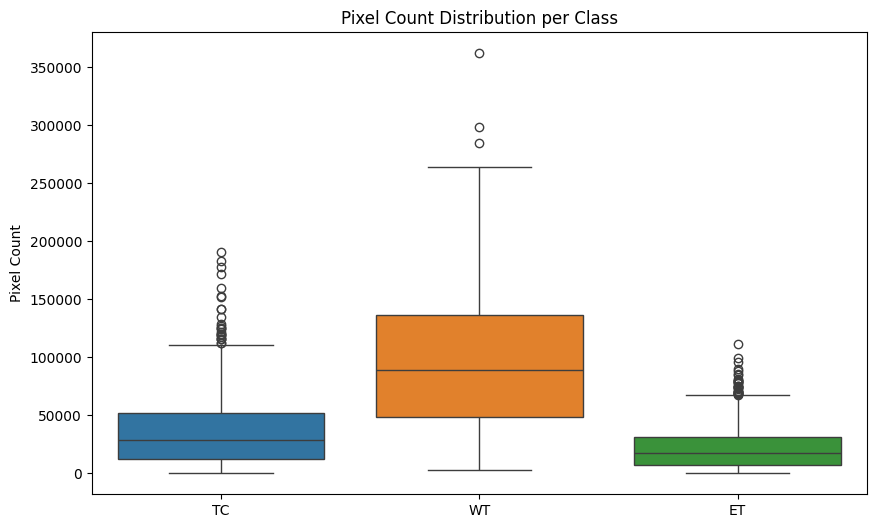

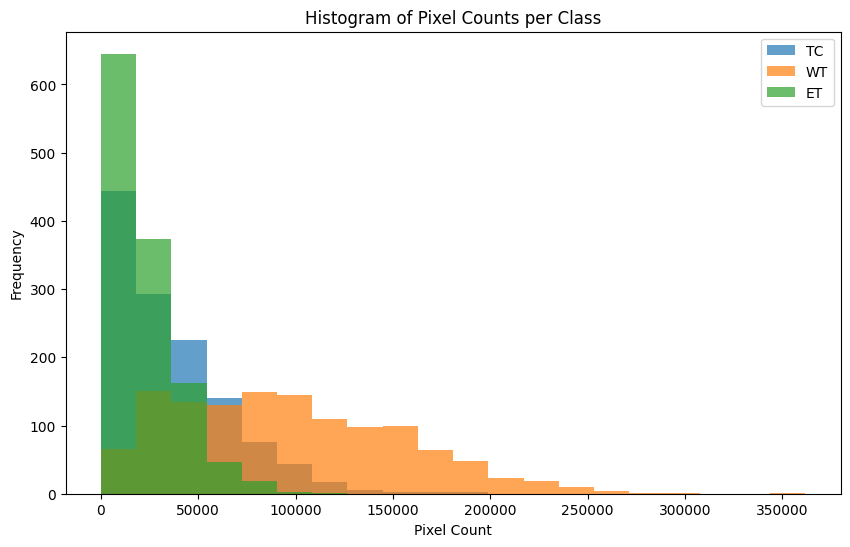


Total Pixel Counts per Class:
 TC     44726987
WT    120055496
ET     26830591
dtype: int64


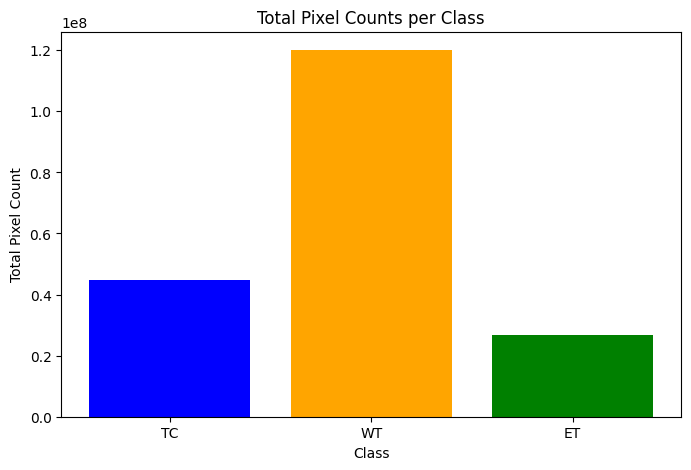


Correlation Matrix:
           TC        WT        ET
TC  1.000000  0.697632  0.738097
WT  0.697632  1.000000  0.590511
ET  0.738097  0.590511  1.000000


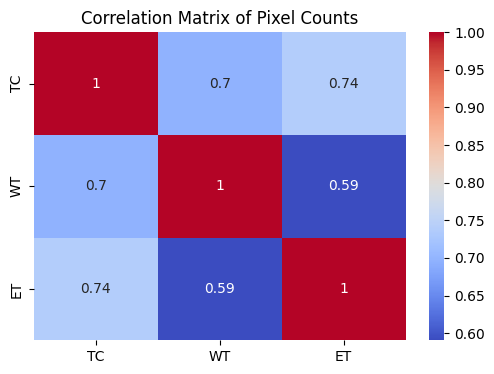

In [24]:
df = pd.DataFrame(class_pixel_counts)

print("type of class_pixel_counts", type(class_pixel_counts))
print("len of dataframe", len(df))
# View the first few rows
print(df.head())

# 1. Statistical Analysis
# Calculate summary statistics
stats = df.describe()
print("\nSummary Statistics:\n", stats)

# 2. Visualization
# Box Plot for Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Pixel Count Distribution per Class')
plt.ylabel('Pixel Count')
plt.show()

# Histogram for Distribution
df.plot(kind='hist', bins=20, alpha=0.7, figsize=(10, 6))
plt.title('Histogram of Pixel Counts per Class')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')
plt.show()

# 3. Class Imbalance Check
# Total counts per class
total_counts = df.sum()
print("\nTotal Pixel Counts per Class:\n", total_counts)

# Bar Chart for Total Counts
plt.figure(figsize=(8, 5))
plt.bar(total_counts.index, total_counts.values, color=['blue', 'orange', 'green'])
plt.title('Total Pixel Counts per Class')
plt.xlabel('Class')
plt.ylabel('Total Pixel Count')
plt.show()

# 4. Correlation Analysis
# Correlation matrix
correlation_matrix = df.corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

# Heatmap of Correlation Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Pixel Counts')
plt.show()

In [25]:
# Identifying outliers using Z-score
from scipy.stats import zscore

# Calculate z-scores
z_scores = np.abs(zscore(df))

# Flagging data points with z-score > 3 as outliers
outliers = (z_scores > 3).any(axis=1)
print("\nOutlier Indices:", np.where(outliers)[0])



Outlier Indices: [  10  139  454  494  678  843  844  873  874  877  879 1004 1023 1026
 1079 1169 1181 1186 1191 1200 1215 1225 1234 1235 1248]


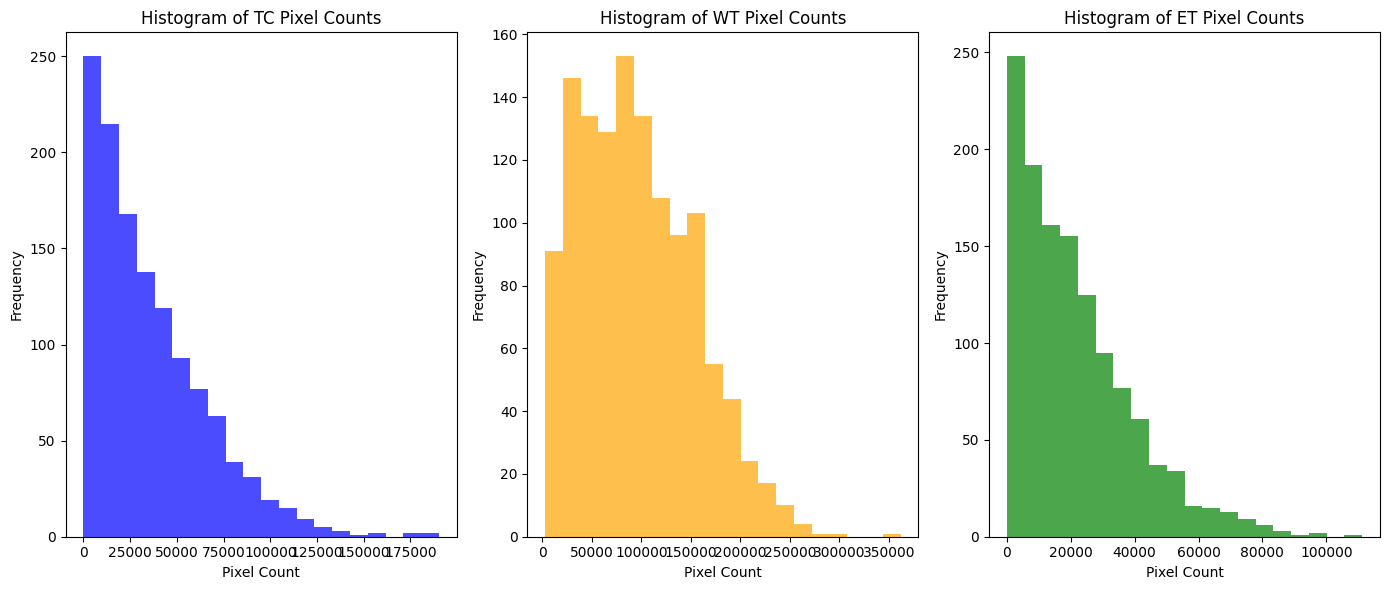

/tmp/ipykernel_53414/2941690601.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['TC'], shade=True, color='blue', label='TC')
/tmp/ipykernel_53414/2941690601.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['WT'], shade=True, color='orange', label='WT')
/tmp/ipykernel_53414/2941690601.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['ET'], shade=True, color='green', label='ET')


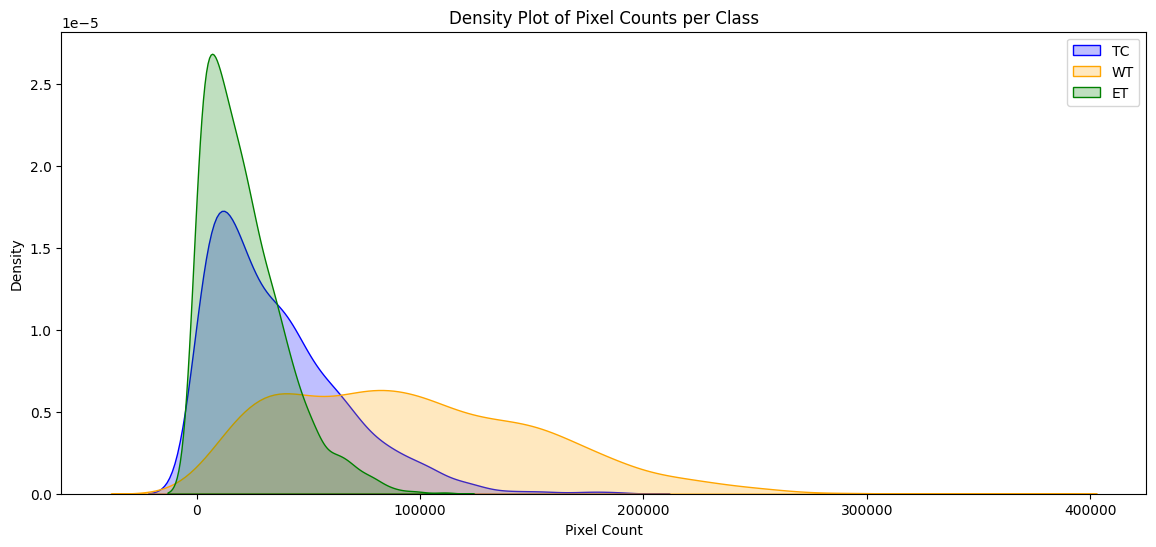

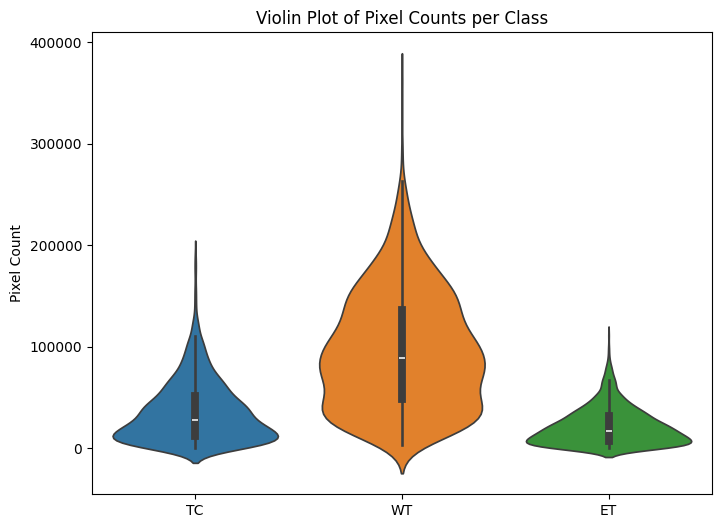

In [26]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.hist(df['TC'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of TC Pixel Counts')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df['WT'], bins=20, color='orange', alpha=0.7)
plt.title('Histogram of WT Pixel Counts')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(df['ET'], bins=20, color='green', alpha=0.7)
plt.title('Histogram of ET Pixel Counts')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 3. Density Plot (KDE) for Each Class
plt.figure(figsize=(14, 6))
sns.kdeplot(df['TC'], shade=True, color='blue', label='TC')
sns.kdeplot(df['WT'], shade=True, color='orange', label='WT')
sns.kdeplot(df['ET'], shade=True, color='green', label='ET')
plt.title('Density Plot of Pixel Counts per Class')
plt.xlabel('Pixel Count')
plt.ylabel('Density')
plt.legend()
plt.show()

# 4. Violin Plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=df)
plt.title('Violin Plot of Pixel Counts per Class')
plt.ylabel('Pixel Count')
plt.show()


In [38]:
class MorphologyTransform(Transform):
    def __init__(self, operation='dilation', kernel_size=3, iterations=1):
        """
        Perform morphological operations: dilation, erosion, opening, or closing on 3D volumes.

        Args:
            operation (str): The type of morphological operation ('dilation', 'erosion', 'opening', 'closing').
            kernel_size (int): Size of the structuring element (cube in 3D).
            iterations (int): Number of times the operation is applied.
        """
        self.operation = operation
        self.kernel_size = kernel_size
        self.iterations = iterations

    def apply_morphology(self, volumes: np.ndarray) -> np.ndarray:
        # Define a 3D structuring element (cube)
        struct_elem = np.ones((self.kernel_size, self.kernel_size, self.kernel_size), dtype=np.uint8)

        # Apply the selected morphological operation
        if self.operation == 'dilation':
            print("dilation applied")
            return np.array([binary_dilation(volume, structure=struct_elem, iterations=self.iterations).astype(volume.dtype)
                             for volume in volumes])
        elif self.operation == 'erosion':
            print("erosion applied")
            return np.array([binary_erosion(volume, structure=struct_elem, iterations=self.iterations).astype(volume.dtype)
                             for volume in volumes])
        elif self.operation == 'opening':
            print("opening applied")
            return np.array([binary_opening(volume, structure=struct_elem, iterations=self.iterations).astype(volume.dtype)
                             for volume in volumes])
        elif self.operation == 'closing':
            print("closing applied")
            return np.array([binary_closing(volume, structure=struct_elem, iterations=self.iterations).astype(volume.dtype)
                             for volume in volumes])
        return volumes

    def __call__(self, volumes: np.ndarray) -> np.ndarray:
        if volumes.ndim == 5:
            # Apply transformation to each volume in parallel
            # print("volume shape is", volumes.shape)
            return self.apply_morphology(volumes)
        elif volumes.ndim == 4:
            # print("volume shape is", volumes.shape)
            # Apply transformation to each volume in parallel
            return self.apply_morphology(volumes)
        else:
            raise ValueError(f"Expected a 4D or 5D tensor, got {volumes.ndim}D.")

class MorphologyTransformd(MapTransform):
    """
    Dictionary-based wrapper for MorphologyTransform to work with MONAI pipelines.
    """
    def __init__(self, keys: Hashable, operation='dilation', kernel_size=3, iterations=1, allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.transform = MorphologyTransform(operation, kernel_size, iterations)

    def __call__(self, data: Mapping[Hashable, np.ndarray]) -> Mapping[Hashable, np.ndarray]:
        d = dict(data)
        for key in self.key_iterator(d):
            volume = d[key]

            # Convert torch tensor to numpy array if necessary
            if isinstance(volume, torch.Tensor):
                volume = volume.cpu().numpy()

            # Apply the morphological transformation on the volume
            volume = self.transform(volume)

            # Convert back to torch tensor and ensure type consistency
            d[key] = torch.from_numpy(volume).float()

        return d my code is this how to modify this code so that data is augmented by applying morphlogical operationbs

SyntaxError: invalid syntax (3014122748.py, line 73)

In [47]:
print(torch.zeros(1024))

tensor([0., 0., 0.,  ..., 0., 0., 0.])
